# Mask Stabilization - Analysis and Demonstration

This notebook demonstrates the complete pipeline for video segmentation and mask stabilization.

## Overview

1. Load and visualize video
2. Perform segmentation using DeepLabv3
3. Apply different stabilization methods
4. Compare results and analyze metrics
5. Visualize improvements

In [1]:
# Import required libraries
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2

from src.segmentation import VideoSegmenter
from src.stabilization import MaskStabilizer
from src.metrics import compare_stability, calculate_mask_statistics
from src.utils import extract_frames, get_video_info, overlay_mask_on_frame

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 5)

print("Libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Libraries imported successfully!


## 1. Load Video

First, we'll load a sample video and examine its properties.

In [2]:
# Path to your video file
# Replace with actual path to your test video
video_path = '../examples/IMG_0802.MOV'

# Get video information
try:
    video_info = get_video_info(video_path)
    print("Video Information:")
    print(f"  FPS: {video_info['fps']}")
    print(f"  Frame Count: {video_info['frame_count']}")
    print(f"  Resolution: {video_info['width']}x{video_info['height']}")
    
    # Extract frames
    frames = extract_frames(video_path)
    print(f"\nExtracted {len(frames)} frames")
except Exception as e:
    print(f"Error loading video: {e}")
    print("\nPlease place a sample video in the examples/ directory")
    frames = None

Video Information:
  FPS: 29.996732382093455
  Frame Count: 918
  Resolution: 1920x1080

Extracted 918 frames


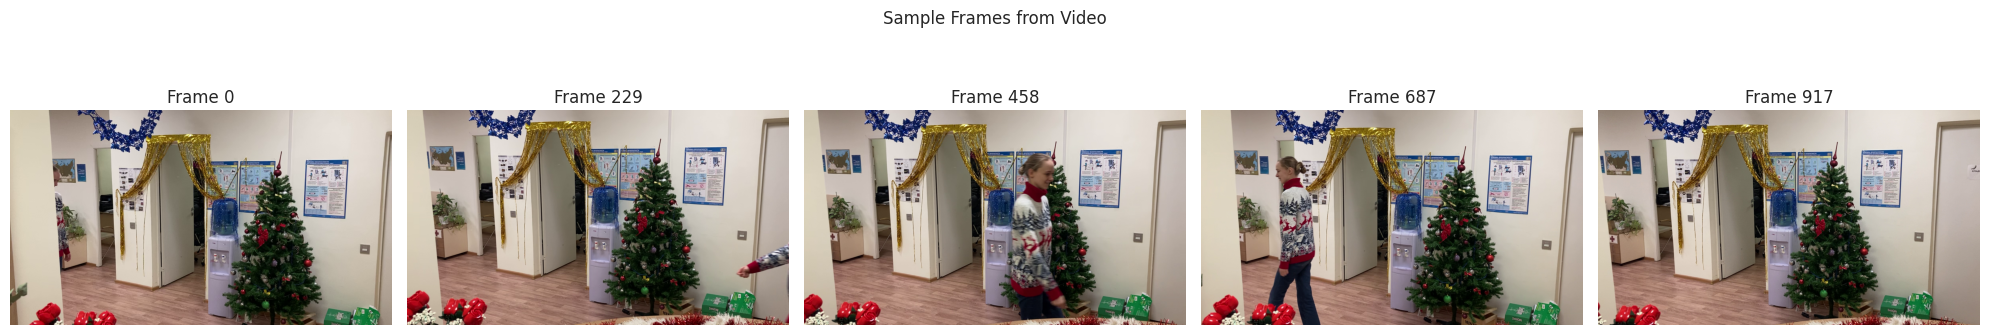

In [3]:
# Visualize some sample frames
if frames is not None and len(frames) > 0:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    indices = np.linspace(0, len(frames)-1, 5, dtype=int)
    
    for i, idx in enumerate(indices):
        frame_rgb = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB)
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f'Frame {idx}')
        axes[i].axis('off')
    
    plt.suptitle('Sample Frames from Video')
    plt.tight_layout()
    plt.show()

## 2. Perform Segmentation

Use DeepLabv3 to segment the video frames.

In [4]:
# Initialize segmenter
segmenter = VideoSegmenter()
print("VideoSegmenter initialized")
print(f"Using device: {segmenter.device}")

# Show available classes
print("\nAvailable segmentation classes:")
for class_id, class_name in segmenter.get_available_classes().items():
    print(f"  {class_id}: {class_name}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████| 233M/233M [00:01<00:00, 135MB/s]


VideoSegmenter initialized
Using device: cuda

Available segmentation classes:
  0: background
  15: person
  7: car
  6: bus
  8: truck
  9: boat
  17: cat
  18: dog
  19: horse
  20: sheep
  21: cow


In [5]:
# Segment video (targeting 'person' class)
if frames is not None:
    target_class = 15  # person
    print(f"Segmenting {len(frames)} frames (target class: person)...")
    
    binary_masks, prob_maps = segmenter.segment_video(
        frames, 
        target_class=target_class,
        batch_size=4
    )
    
    print(f"Segmentation complete!")
    print(f"  Binary masks: {len(binary_masks)}")
    print(f"  Probability maps: {len(prob_maps)}")

Segmenting 918 frames (target class: person)...
Segmentation complete!
  Binary masks: 918
  Probability maps: 918


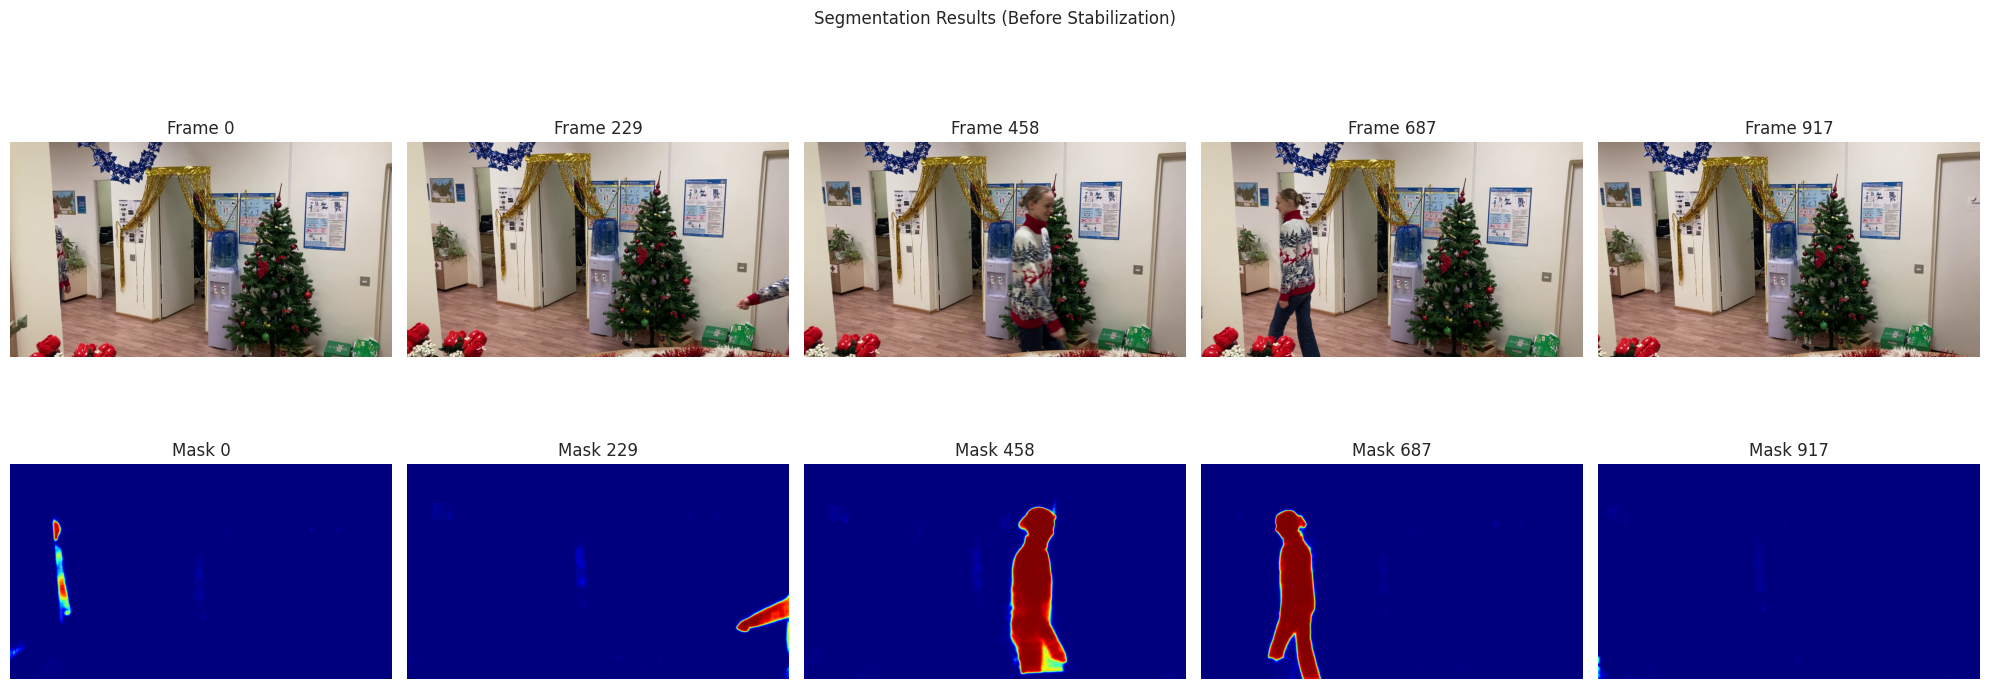

In [6]:
# Visualize segmentation results
if frames is not None and len(prob_maps) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    indices = np.linspace(0, len(frames)-1, 5, dtype=int)
    
    for i, idx in enumerate(indices):
        # Original frame
        frame_rgb = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(frame_rgb)
        axes[0, i].set_title(f'Frame {idx}')
        axes[0, i].axis('off')
        
        # Segmentation mask
        axes[1, i].imshow(prob_maps[idx], cmap='jet', vmin=0, vmax=1)
        axes[1, i].set_title(f'Mask {idx}')
        axes[1, i].axis('off')
    
    plt.suptitle('Segmentation Results (Before Stabilization)')
    plt.tight_layout()
    plt.show()

## 3. Analyze Initial Stability

Calculate metrics for the original segmentation masks.

In [7]:
# Calculate statistics
if 'prob_maps' in locals():
    stats = calculate_mask_statistics(prob_maps)
    print("Mask Statistics (Before Stabilization):")
    print(f"  Number of frames: {stats['num_frames']}")
    print(f"  Average mask area: {stats['area']['mean']:.2f}%")
    print(f"  Area std dev: {stats['area']['std']:.2f}%")
    print(f"  Temporal consistency (mean IoU): {stats['temporal_consistency']['mean']:.4f}")
    print(f"  Temporal consistency std: {stats['temporal_consistency']['std']:.4f}")

Mask Statistics (Before Stabilization):
  Number of frames: 918
  Average mask area: 5.30%
  Area std dev: 3.40%
  Temporal consistency (mean IoU): 0.8404
  Temporal consistency std: 0.1601


## 4. Apply Stabilization Methods

Test different stabilization methods and compare results.

In [8]:
# Test different methods
if 'prob_maps' in locals():
    stabilization_results = {}
    
    # Method 1: Moving Average
    print("Applying Moving Average (window=5)...")
    masks_ma = MaskStabilizer.moving_average(prob_maps, window_size=5)
    stabilization_results['moving_average'] = masks_ma
    
    # Method 2: Median Filter
    print("Applying Median Filter (window=5)...")
    masks_median = MaskStabilizer.median_filter(prob_maps, window_size=5)
    stabilization_results['median_filter'] = masks_median
    
    # Method 3: Exponential Smoothing
    print("Applying Exponential Smoothing (alpha=0.3)...")
    masks_exp = MaskStabilizer.exponential_smoothing(prob_maps, alpha=0.3)
    stabilization_results['exponential_smoothing'] = masks_exp
    
    print("\nAll stabilization methods applied!")

Applying Moving Average (window=5)...
Applying Median Filter (window=5)...
Applying Exponential Smoothing (alpha=0.3)...

All stabilization methods applied!


## 5. Compare Results

Calculate and visualize metrics for each method.

In [9]:
# Compare each method
if 'stabilization_results' in locals():
    comparison_metrics = {}
    
    for method_name, masks_after in stabilization_results.items():
        metrics = compare_stability(prob_maps, masks_after)
        comparison_metrics[method_name] = metrics
        
        print(f"\n{'='*60}")
        print(f"Method: {method_name.upper()}")
        print(f"{'='*60}")
        print(f"IoU Before: {metrics['iou_before']['mean']:.4f} ± {metrics['iou_before']['std']:.4f}")
        print(f"IoU After:  {metrics['iou_after']['mean']:.4f} ± {metrics['iou_after']['std']:.4f}")
        print(f"Improvement: {metrics['improvement']['iou_improvement']:.4f} ({metrics['improvement']['iou_improvement_percent']:.2f}%)")
        print(f"\nInstability Before: {metrics['instability_before']['mean']:.4f}")
        print(f"Instability After:  {metrics['instability_after']['mean']:.4f}")
        print(f"Reduction: {metrics['improvement']['instability_reduction']:.4f} ({metrics['improvement']['instability_reduction_percent']:.2f}%)")


Method: MOVING_AVERAGE
IoU Before: 0.8404 ± 0.1601
IoU After:  0.8666 ± 0.1256
Improvement: 0.0262 (3.12%)

Instability Before: 0.1596
Instability After:  0.1334
Reduction: 0.0262 (16.42%)

Method: MEDIAN_FILTER
IoU Before: 0.8404 ± 0.1601
IoU After:  0.8689 ± 0.1236
Improvement: 0.0285 (3.39%)

Instability Before: 0.1596
Instability After:  0.1311
Reduction: 0.0285 (17.84%)

Method: EXPONENTIAL_SMOOTHING
IoU Before: 0.8404 ± 0.1601
IoU After:  0.8622 ± 0.1311
Improvement: 0.0218 (2.59%)

Instability Before: 0.1596
Instability After:  0.1378
Reduction: 0.0218 (13.65%)


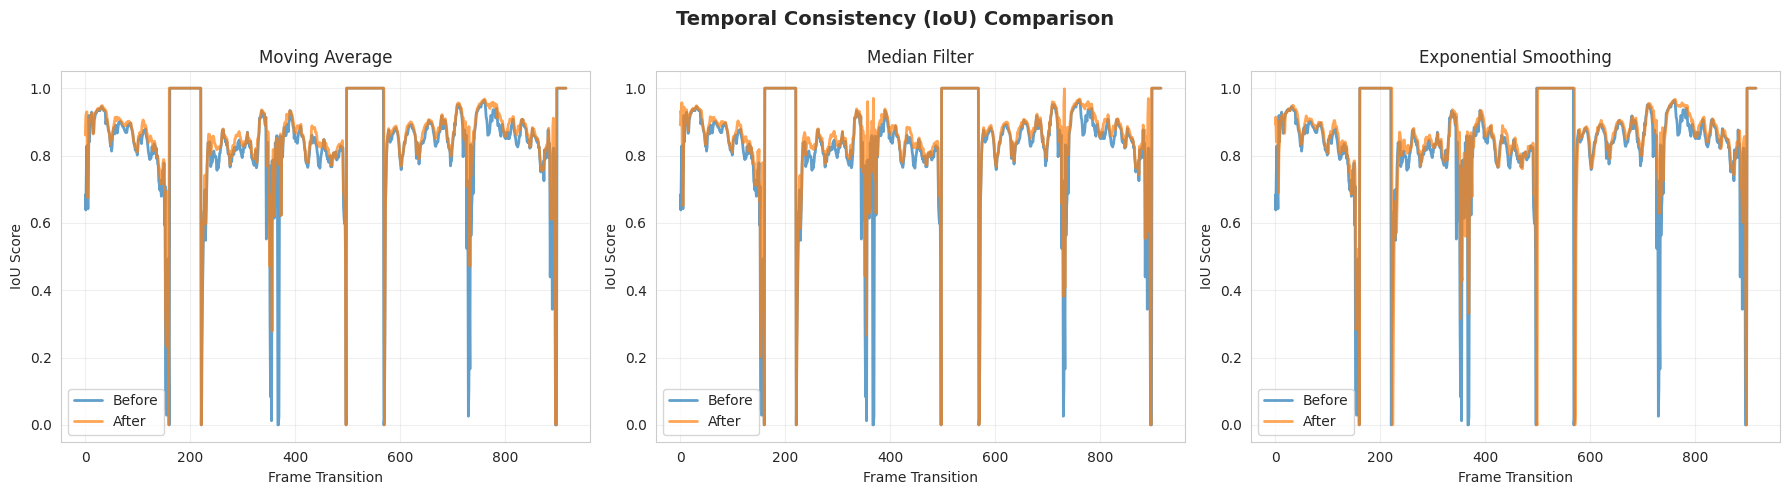

In [10]:
# Visualize IoU comparison
if 'comparison_metrics' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (method_name, metrics) in enumerate(comparison_metrics.items()):
        frame_indices = range(len(metrics['iou_before']['scores']))
        
        axes[idx].plot(frame_indices, metrics['iou_before']['scores'], 
                      label='Before', alpha=0.7, linewidth=2)
        axes[idx].plot(frame_indices, metrics['iou_after']['scores'], 
                      label='After', alpha=0.7, linewidth=2)
        axes[idx].set_xlabel('Frame Transition')
        axes[idx].set_ylabel('IoU Score')
        axes[idx].set_title(f'{method_name.replace("_", " ").title()}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('Temporal Consistency (IoU) Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

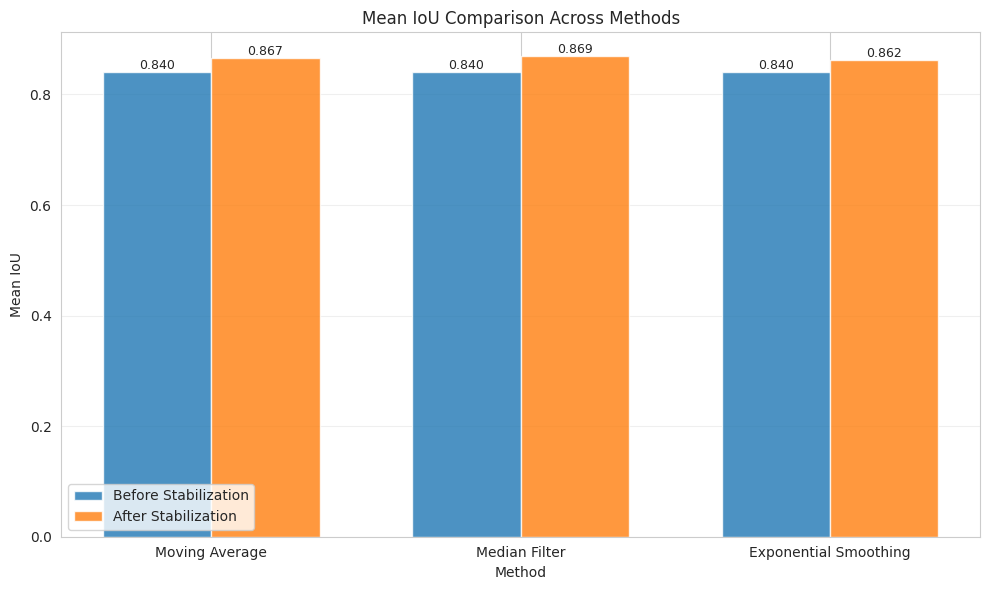

In [11]:
# Bar chart comparison
if 'comparison_metrics' in locals():
    methods = list(comparison_metrics.keys())
    iou_before = [comparison_metrics[m]['iou_before']['mean'] for m in methods]
    iou_after = [comparison_metrics[m]['iou_after']['mean'] for m in methods]
    
    x = np.arange(len(methods))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, iou_before, width, label='Before Stabilization', alpha=0.8)
    bars2 = ax.bar(x + width/2, iou_after, width, label='After Stabilization', alpha=0.8)
    
    ax.set_xlabel('Method')
    ax.set_ylabel('Mean IoU')
    ax.set_title('Mean IoU Comparison Across Methods')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in methods])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 6. Visual Comparison

Side-by-side comparison of masks before and after stabilization.

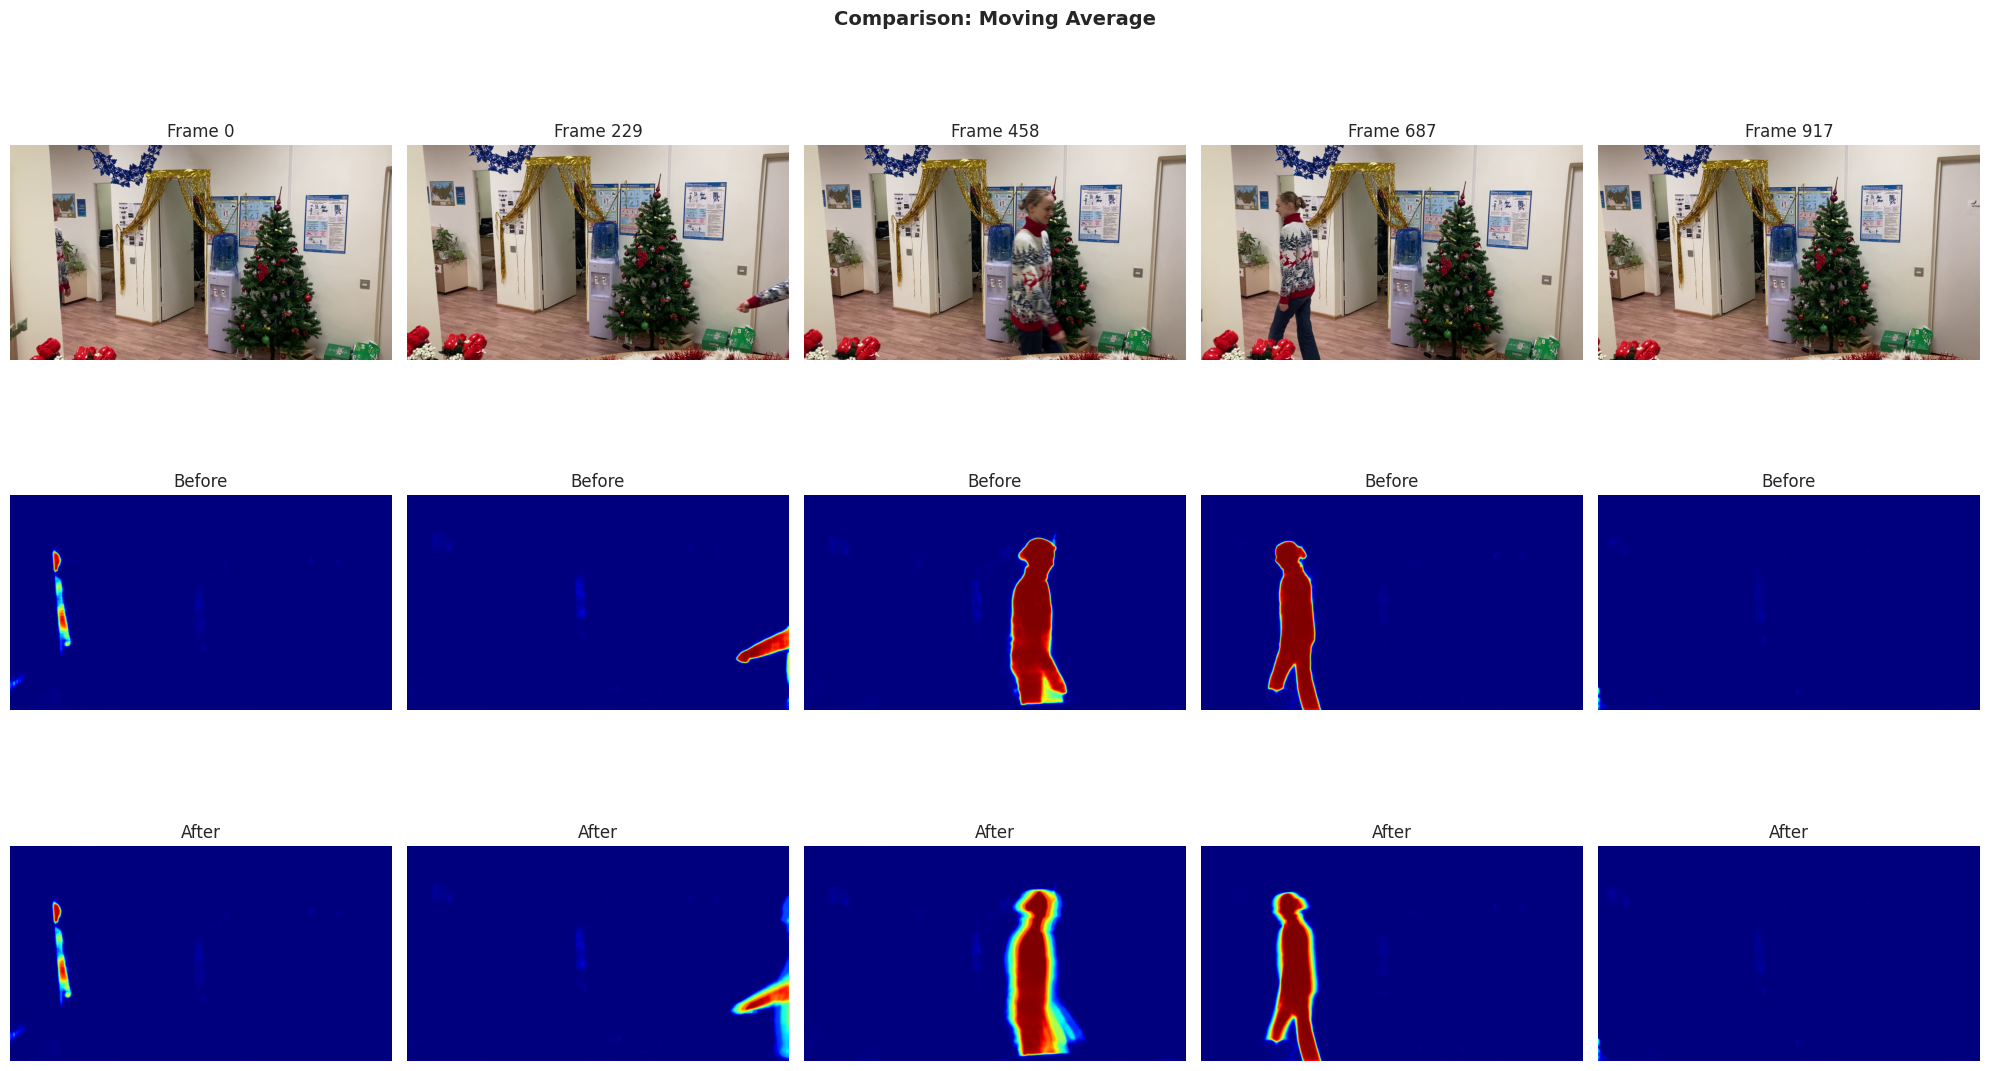

In [12]:
# Select best method for visualization
if 'stabilization_results' in locals():
    # Use moving average for this example
    best_method = 'moving_average'
    masks_stabilized = stabilization_results[best_method]
    
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    indices = np.linspace(0, len(frames)-1, 5, dtype=int)
    
    for i, idx in enumerate(indices):
        # Original frame
        frame_rgb = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(frame_rgb)
        axes[0, i].set_title(f'Frame {idx}')
        axes[0, i].axis('off')
        
        # Before stabilization
        axes[1, i].imshow(prob_maps[idx], cmap='jet', vmin=0, vmax=1)
        axes[1, i].set_title('Before')
        axes[1, i].axis('off')
        
        # After stabilization
        axes[2, i].imshow(masks_stabilized[idx], cmap='jet', vmin=0, vmax=1)
        axes[2, i].set_title('After')
        axes[2, i].axis('off')
    
    plt.suptitle(f'Comparison: {best_method.replace("_", " ").title()}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 7. Summary and Conclusions

Key findings from the analysis.

In [13]:
print("\n" + "="*80)
print("SUMMARY OF RESULTS")
print("="*80)

if 'comparison_metrics' in locals():
    # Find best method
    best_method = max(comparison_metrics.items(), 
                     key=lambda x: x[1]['improvement']['iou_improvement'])
    
    print(f"\nBest Method: {best_method[0].replace('_', ' ').title()}")
    print(f"  IoU Improvement: {best_method[1]['improvement']['iou_improvement']:.4f}")
    print(f"  Improvement Percentage: {best_method[1]['improvement']['iou_improvement_percent']:.2f}%")
    print(f"  Instability Reduction: {best_method[1]['improvement']['instability_reduction_percent']:.2f}%")
    
    print("\nAll Methods Performance:")
    for method_name, metrics in sorted(comparison_metrics.items(), 
                                      key=lambda x: x[1]['improvement']['iou_improvement'],
                                      reverse=True):
        print(f"\n  {method_name.replace('_', ' ').title()}:")
        print(f"    Mean IoU: {metrics['iou_after']['mean']:.4f}")
        print(f"    Improvement: {metrics['improvement']['iou_improvement_percent']:.2f}%")

print("\n" + "="*80)


SUMMARY OF RESULTS

Best Method: Median Filter
  IoU Improvement: 0.0285
  Improvement Percentage: 3.39%
  Instability Reduction: 17.84%

All Methods Performance:

  Median Filter:
    Mean IoU: 0.8689
    Improvement: 3.39%

  Moving Average:
    Mean IoU: 0.8666
    Improvement: 3.12%

  Exponential Smoothing:
    Mean IoU: 0.8622
    Improvement: 2.59%



## Conclusions

*(Fill in your observations here)*

1. **Segmentation Quality**: 
   - Describe the quality of initial segmentation
   - Note any challenges or artifacts

2. **Stabilization Effectiveness**:
   - Which method worked best?
   - Trade-offs between methods

3. **Recommendations**:
   - Best use cases for each method
   - Parameter tuning suggestions